# Data Analysis & feature engineering 

## outline:

- 1. [Import Libraries](#01)

- 2. [Load Dataset](#02)

- 3. [Target Variable](#03)

- 4. [Variables Type](#04)

- 5. [Missing Data](#05)

- 6. [Duplicated Values](#06)

        Identifying Duplicates: Check for and handle any duplicated rows in the dataset.

- 7. [Numerical Variables](#07)

    - 7.1. Temporal Variables : Date and Time
    - 7.2. Discrete Variables
    - 7.3. Continuous Variables
    - 7.4. Skewed Variables

- 8. [Categorical Variables](#08)
    - 8.1. Cardinality
    - 8.2. Quality Variables
    - 8.3. Rare Labels


- 9. [Correlation](#09) 

    * Correlation Matrix: 

- 10. [Split the data](#10)

- 11. [Identifying Outliers](#11)

    * Outlier Detection: Use statistical methods (e.g., Z-score, IQR) to identify and handle outliers in numerical variables.

- 12. [Data Scaling](#12)

- 13. [Save the data](#13)



---
<a id="01"></a>
### step1: Import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats

import joblib
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

import warnings 
warnings.filterwarnings("ignore")

---
<a id="02"></a>
### Step2: Load the Data

In [2]:
train = pd.read_csv(r'../Data/train.csv')
Val = pd.read_csv(r'../Data/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(len(train.columns))

81


---

**Processing 1:** `Remove Id column`

---

In [4]:
# first let's remove the id col
train = train.drop('Id', axis=1)
Val = Val.drop('Id', axis=1)

In [5]:
print(f"The shape of the data is {train.shape}")

The shape of the data is (1460, 80)


after the processing 1 ==>

* we have 81 columns

<hr>

<a id="03"></a>

### 3. Target Variable

In [6]:
# divide data into features and target

X_train = train.drop("SalePrice", axis=1)
y_train = train["SalePrice"]

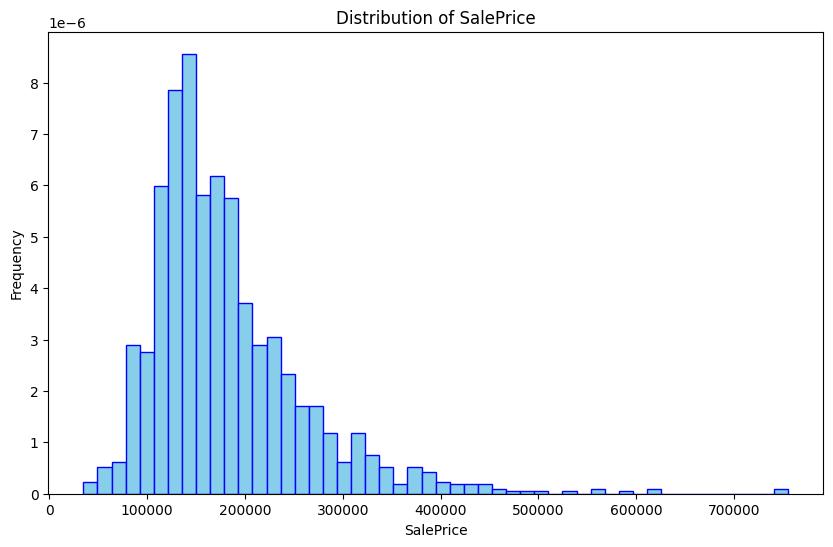

In [7]:
# visualize the targe variable 

def Frequency_distribution(col):
    plt.figure(figsize=(10, 6))
    plt.hist(
        train[col],
        bins=50,
        color="skyblue",
        edgecolor="b",
        density=True
    )
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()
    
    
Frequency_distribution('SalePrice')

---

**Processing 2:** `apply the log transformation to the target variable`

---

#### Notes:

- we can see that the target variable is continuous and the distribution is skewed to the right.

- we can improve the value spread with a mathematical transformation.

- we can use the `log transformation` to ***reduce*** **the skew.**

### Apply the log transformation to the target variable

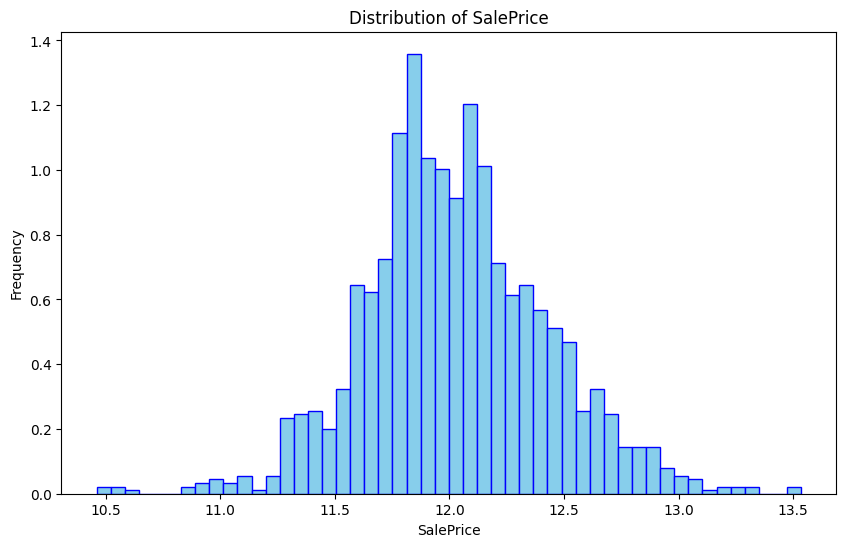

In [8]:
train['SalePrice'] = np.log(train['SalePrice'])

Frequency_distribution('SalePrice')

now the target variable is a Gaussian distribution 

---
<a id="04"></a>
### 4. Variables Types 

In [9]:
numerical_columns = [col for col in train.columns if train[col].dtype != 'O']
categorical_columns = [col for col in train.columns if train[col].dtype == 'O']
numerical_columns.remove('SalePrice')

### if we check the data_description we can see that the column MSSubClass is a categorical variable so let's add it to the list of categorical variables

numerical_columns.remove('MSSubClass')
categorical_columns.append('MSSubClass')

print(f"The number of numerical columns is {len(numerical_columns)}")
print(f"The number of categorical columns is {len(categorical_columns)}")

The number of numerical columns is 35
The number of categorical columns is 44


---

<a id="05"></a>
### 5. Handle Missing Values 

In [10]:
col_missing = []
for col in train.columns:
    if train[col].isnull().sum() > 0:
        col_missing.append(col)
        
print(col_missing)
print(f"columns with missing values: {len(col_missing)}")

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
columns with missing values: 19


In [11]:
col_missing = []
for col in train.columns:
    if train[col].isnull().sum() > 0 and train[col].dtype != 'object':
        col_missing.append(col)
        
print(col_missing)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


Text(0.5, 1.0, 'Missing Values In the Train dataset')

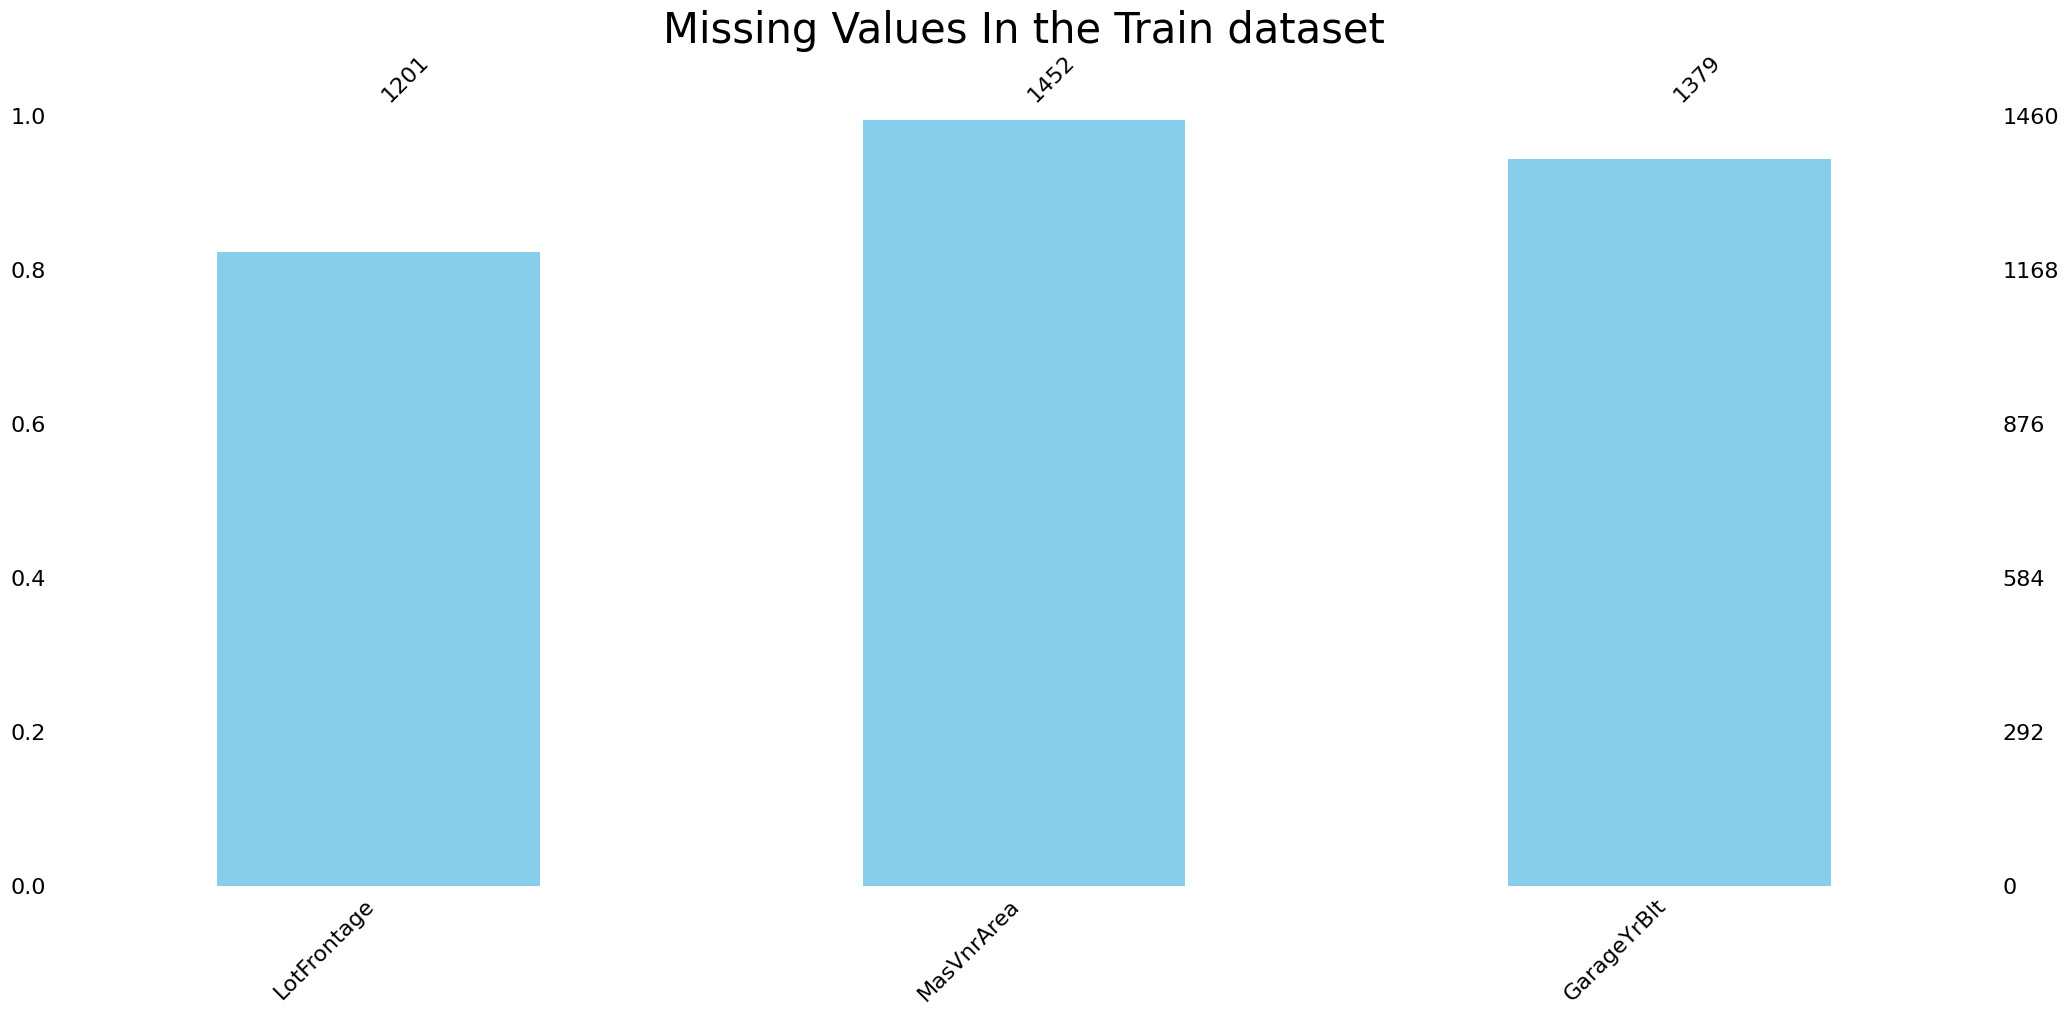

In [12]:
plt.figure(figsize=(8,6))
msno.bar(train[col_missing],color='skyblue',fontsize=16)
plt.title('Missing Values In the Train dataset',fontsize=30)

---

**Processing 3:** `Remove this columns ['Alley', 'PoolQC', 'Fence', 'MiscFeature']`

---

In [13]:
# first we will remove the columns with more than 1000 null values

# remove them from the training dataset 
col_drop = [col for col in train.columns if train[col].isnull().sum() > 1000]
train = train.drop(col_drop, axis=1)
col_drop


['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [14]:
# remove them from the Validation dataset 
Val = Val.drop(col_drop, axis=1)
col_drop

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [15]:
col_missing = []
for col in train.columns:
    if train[col].isnull().sum() > 0:
        col_missing.append(col)
print(len(col_missing))
print(train.shape)

15
(1460, 76)


In [16]:
## Update the columns types

numerical_columns = [col for col in train.columns if train[col].dtype != 'O']
categorical_columns = [col for col in train.columns if train[col].dtype == 'O']
numerical_columns.remove('SalePrice')

### if we check the data_description we can see that the column MSSubClass is a categorical variable so let's add it to the list of categorical variables

numerical_columns.remove('MSSubClass')
categorical_columns.append('MSSubClass')

print(f"The number of numerical columns is {len(numerical_columns)}")
print(f"The number of categorical columns is {len(categorical_columns)}")

The number of numerical columns is 35
The number of categorical columns is 40


---

**Processing 4:** `Handle the missing values`

---

Text(0.5, 1.0, 'Missing Values')

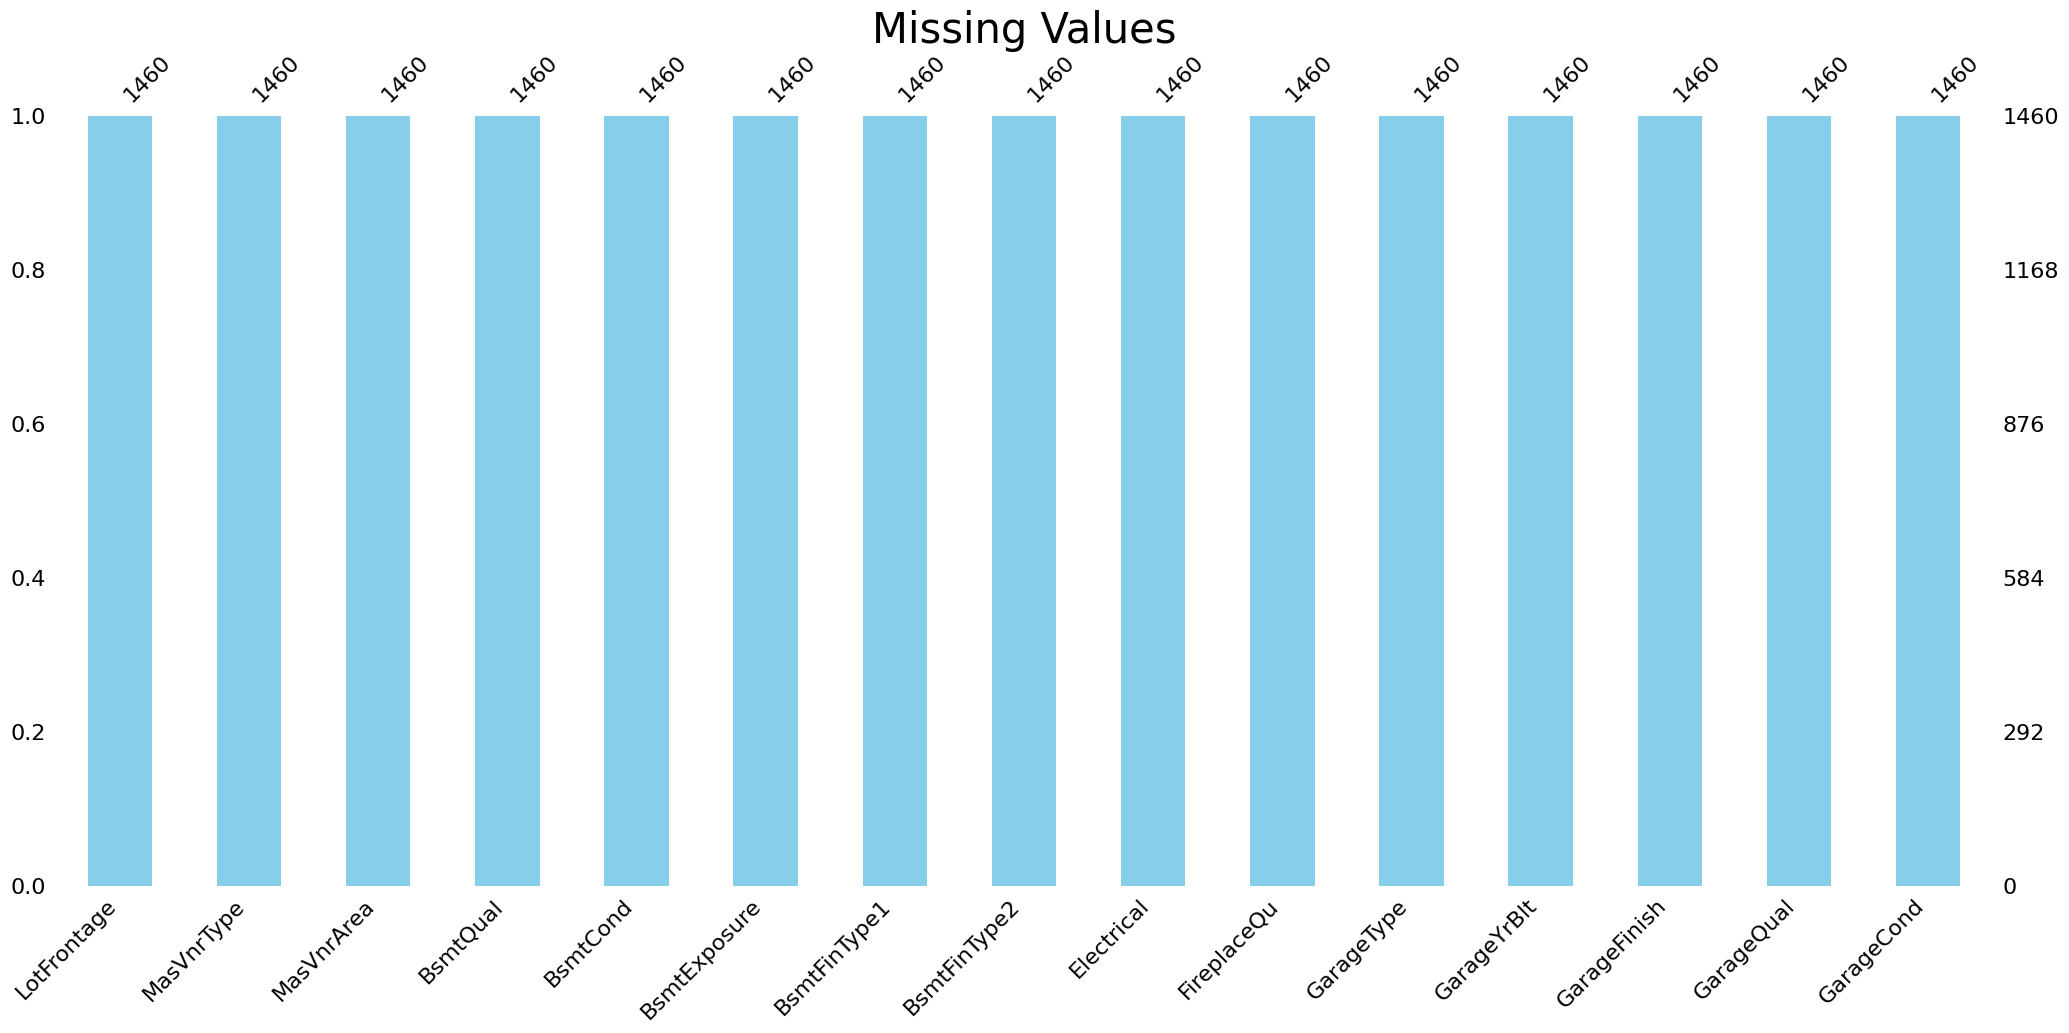

In [17]:
col_missing_cat = [col for col in col_missing if train[col].dtype == 'object']
col_missing_num = [col for col in col_missing if col not in col_missing_cat]


for col in col_missing_num:
    train[col] = train[col].fillna(np.mean(train[col]))

for col in col_missing_cat:
    train[col] = train[col].fillna(train[col].mode()[0])

plt.figure(figsize=(8,6))
msno.bar(train[col_missing],color='skyblue',fontsize=16)
plt.title('Missing Values',fontsize=30)


In [18]:
col_missing = []
for col in Val.columns:
    if Val[col].isnull().sum() > 0:
        col_missing.append(col)
print(len(col_missing))
print(Val.shape)

29
(1459, 75)


Text(0.5, 1.0, 'Missing Values')

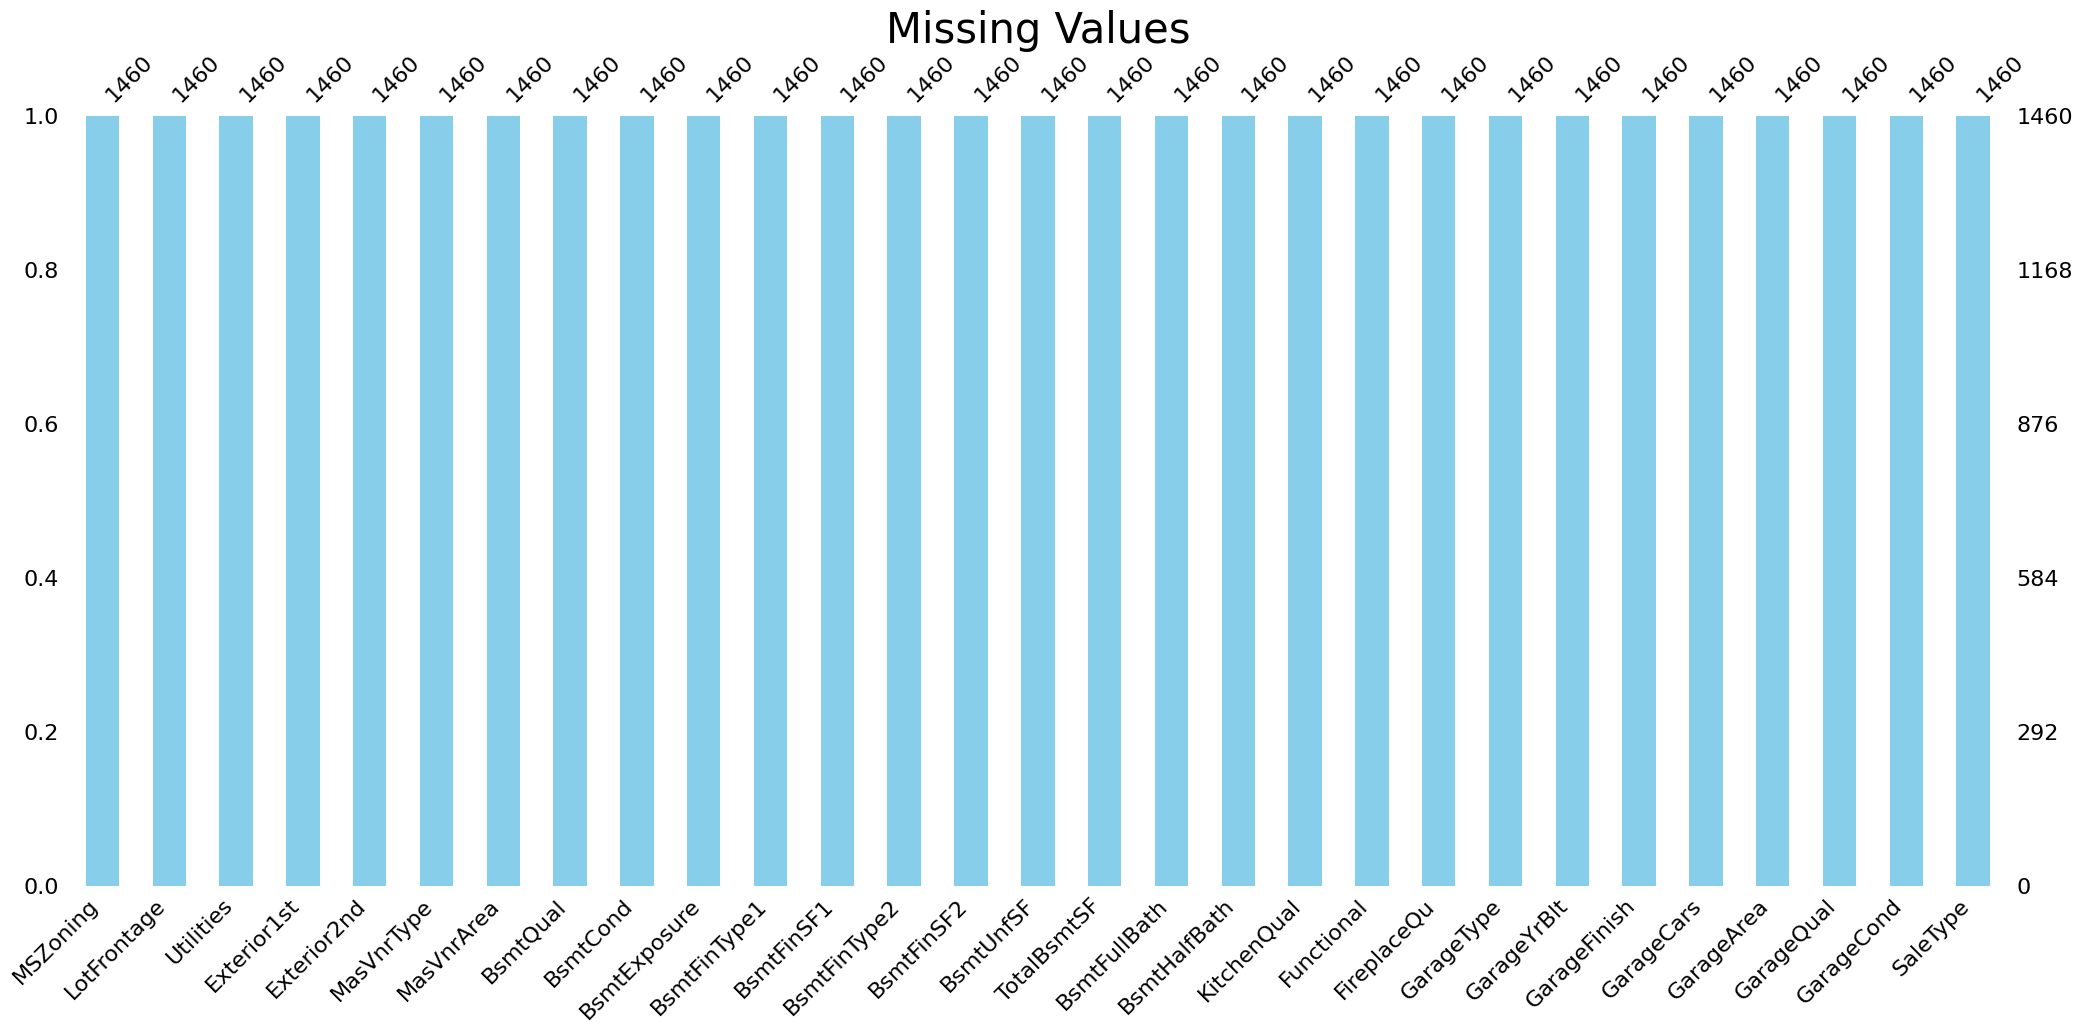

In [19]:
col_missing_cat = [col for col in col_missing if Val[col].dtype == 'object']
col_missing_num = [col for col in col_missing if col not in col_missing_cat]


for col in col_missing_num:
    Val[col] = Val[col].fillna(np.mean(Val[col]))

for col in col_missing_cat:
    Val[col] = Val[col].fillna(Val[col].mode()[0])

plt.figure(figsize=(8,6))
msno.bar(train[col_missing],color='skyblue',fontsize=16)
plt.title('Missing Values',fontsize=30)

---

<a id="06"></a>

### 6. Duplicated Values 

In [20]:
train.duplicated().sum()

np.int64(0)

In [21]:
Val.duplicated().sum()

np.int64(0)

---

<a id="07"></a>
### 7. Numerical Variables

In [22]:
print(f"we have {len(numerical_columns)} columns in the dataset")

we have 35 columns in the dataset


In [23]:
train[numerical_columns].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,836,192,84,0,0,0,0,0,12,2008


#### 7.1 Temporal variables
We have 4 year variables in the dataset:

- YearBuilt: year in which the house was built
- YearRemodAdd: year in which the house was remodeled
- GarageYrBlt: year in which a garage was built
- YrSold: year in which the house was sold


In [24]:
year_var = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
for col in year_var:
    numerical_columns.remove(col)

Text(0, 0.5, 'Median House Price')

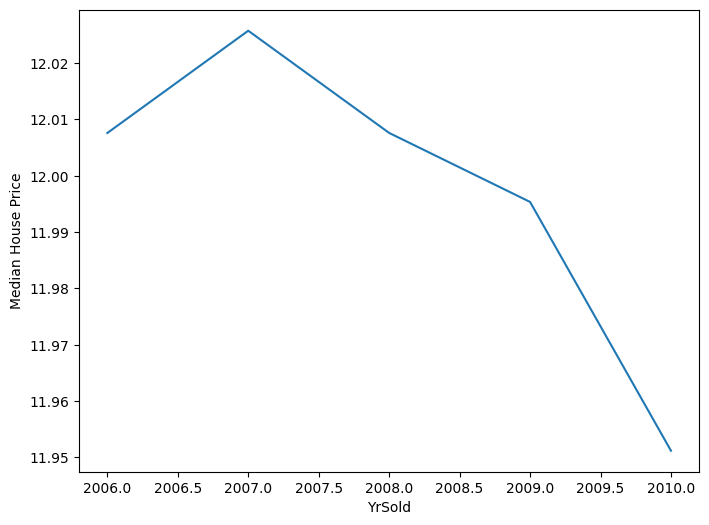

In [25]:
plt.figure(figsize=(8, 6))
train.groupby('YrSold')['SalePrice'].median().plot()
plt.ylabel('Median House Price')

Text(0, 0.5, 'Median House Price')

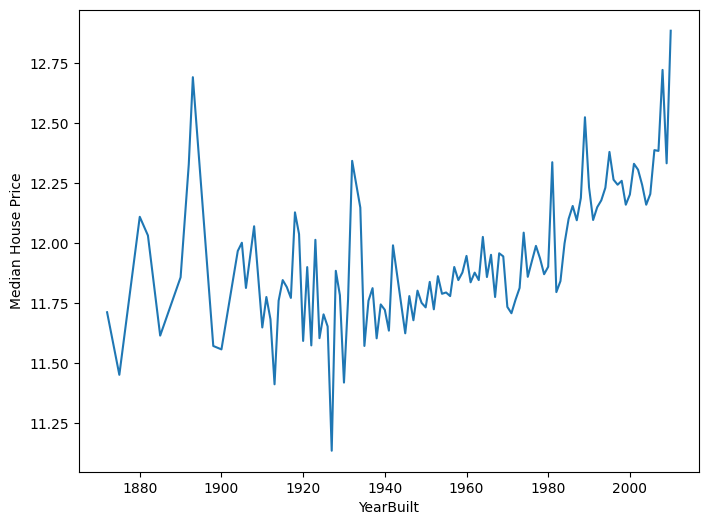

In [26]:
plt.figure(figsize=(8, 6))
train.groupby('YearBuilt')['SalePrice'].median().plot()
plt.ylabel('Median House Price')

In [27]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [28]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    train = elapsed_years(train, var)
    Val = elapsed_years(Val, var)
    
# now we drop YrSold
train.drop(['YrSold'], axis=1, inplace=True)
Val.drop(['YrSold'], axis=1, inplace=True)

### 7.2 Discrete numerical Variables

In [29]:
discrete_var = [var for var in numerical_columns if len(train[var].unique())<20]
print(f"The number of discrete variables is : {len(discrete_var)}")

The number of discrete variables is : 13


<Figure size 1800x2500 with 0 Axes>

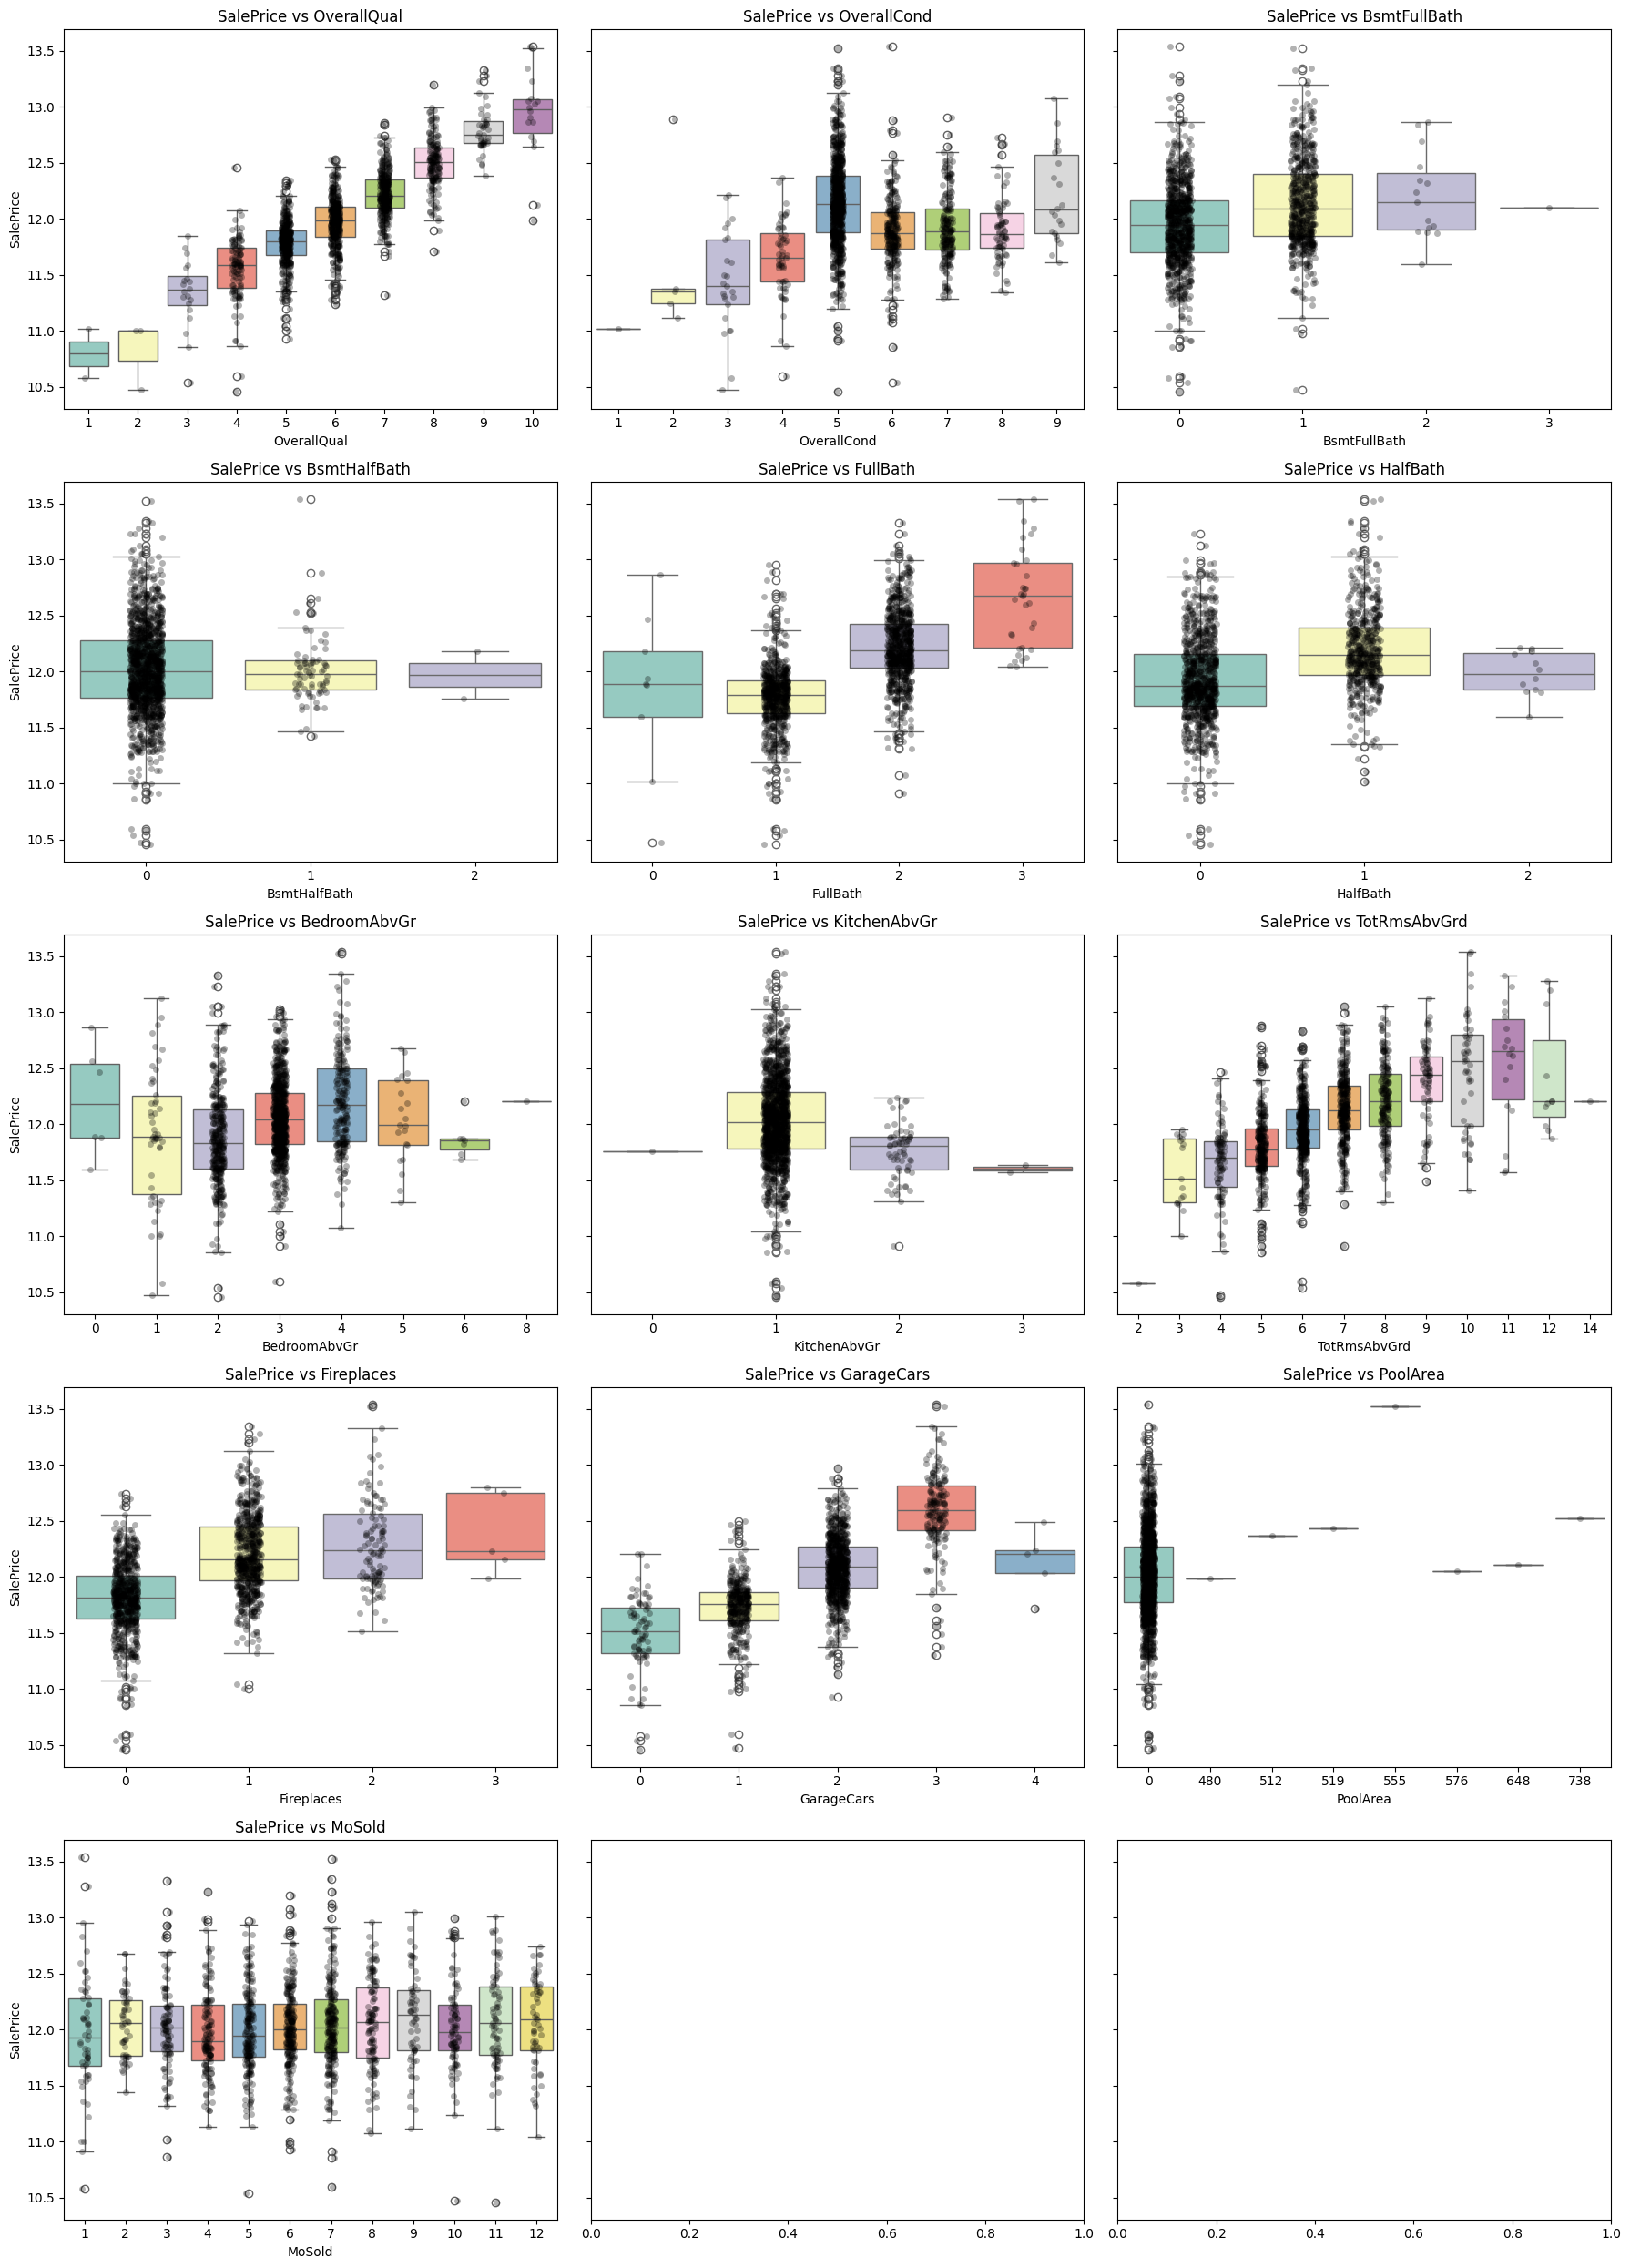

In [30]:
num_cols = 3
num_rows = math.ceil(13 / num_cols)

plt.figure(figsize=(num_cols * 6, num_rows * 5))  

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5), sharey=True)
axes = axes.flatten()  # Flatten in case of multiple rows

for idx, var in enumerate(discrete_var):
    ax = axes[idx]

    sns.boxplot(x=var, y='SalePrice', data=train, ax=ax, palette="Set3")
    sns.stripplot(x=var, y='SalePrice', data=train, ax=ax, jitter=0.1, alpha=0.3, color='k')
    ax.set_title(f'SalePrice vs {var}')
plt.tight_layout()
plt.show()

For most discrete numerical variables, we see an increase in the sale price, with the quality, or overall condition, or number of rooms, or surface.

For some variables, we don't see this tendency. Most likely that variable is not a good predictor of sale price.


#### 7.3 Continuous variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not temporal or discrete.

In [31]:
len(numerical_columns)

31

In [32]:
continuous_var = [var for var in numerical_columns if var not in discrete_var]
len(continuous_var)

18

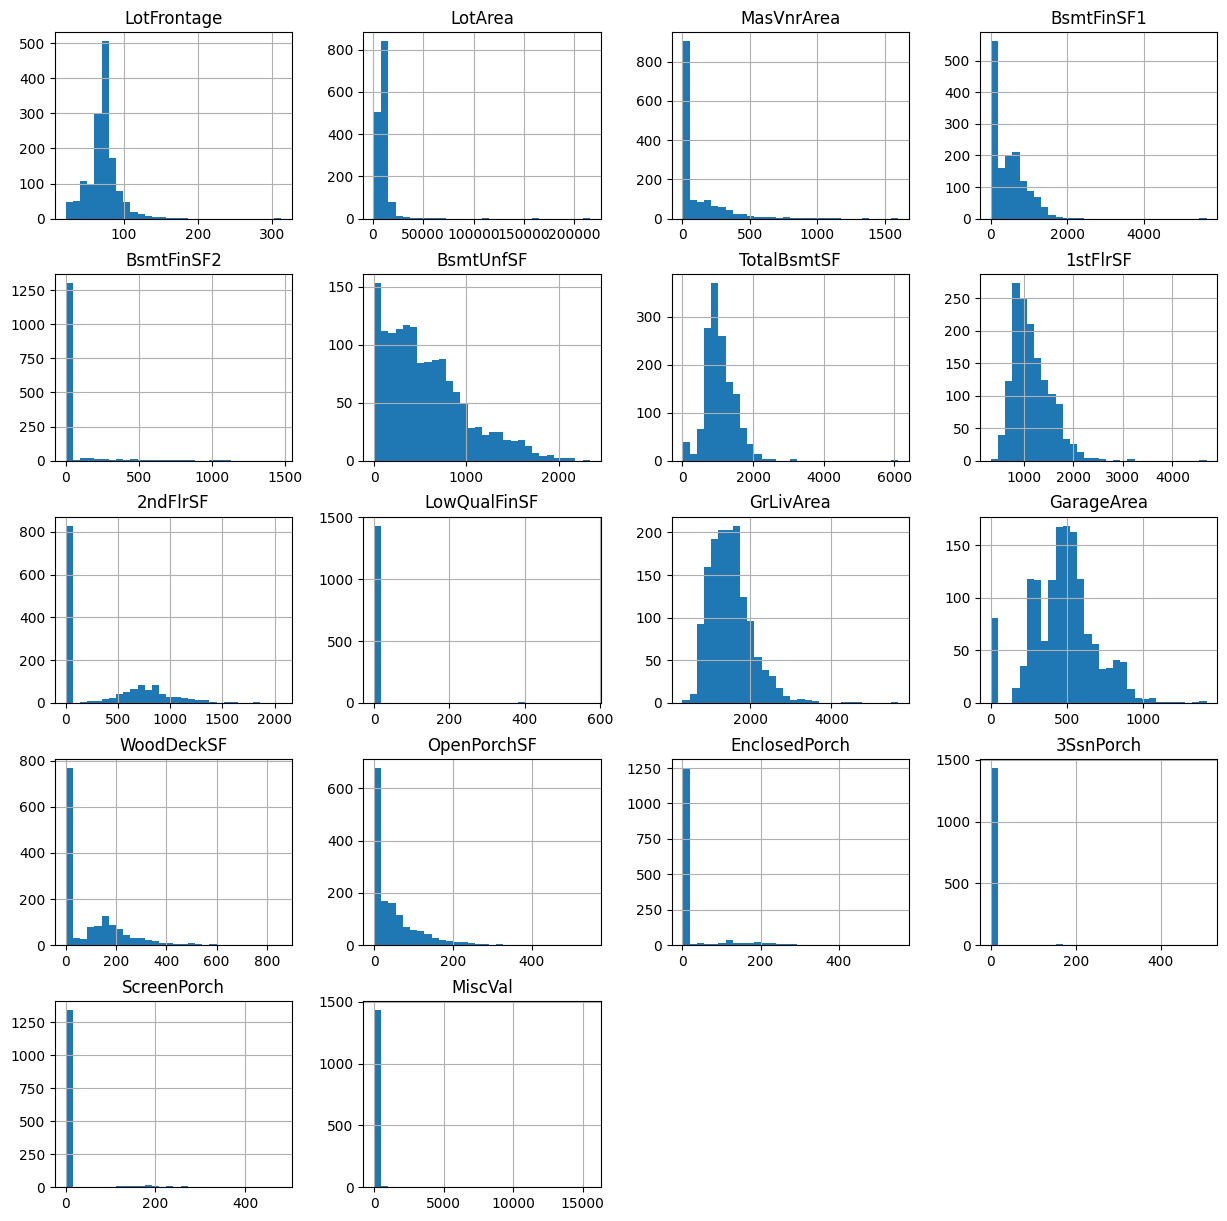

In [33]:
train[continuous_var].hist(bins=30,figsize=(15, 15))
plt.show()

Sometimes, transforming the variables to improve the value spread, improves the model performance. But it is unlikely that a transformation will help change the distribution of the super skewed variables dramatically.

We can apply a Yeo-Johnson transformation to variables like LotFrontage, LotArea, BsmUnfSF, and a binary transformation to variables like 3SsnPorch, ScreenPorch and MiscVal.

Let's go ahead and do that.

In [34]:
# first make a list with the super skewed variables


skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for col in skewed:
    continuous_var.remove(col)
print(len(continuous_var))

12


--- 

**Processing 5:** `apply Yeo-Johnson Transformation`

---

#### 7.3 Yeo-Johnson Transformation

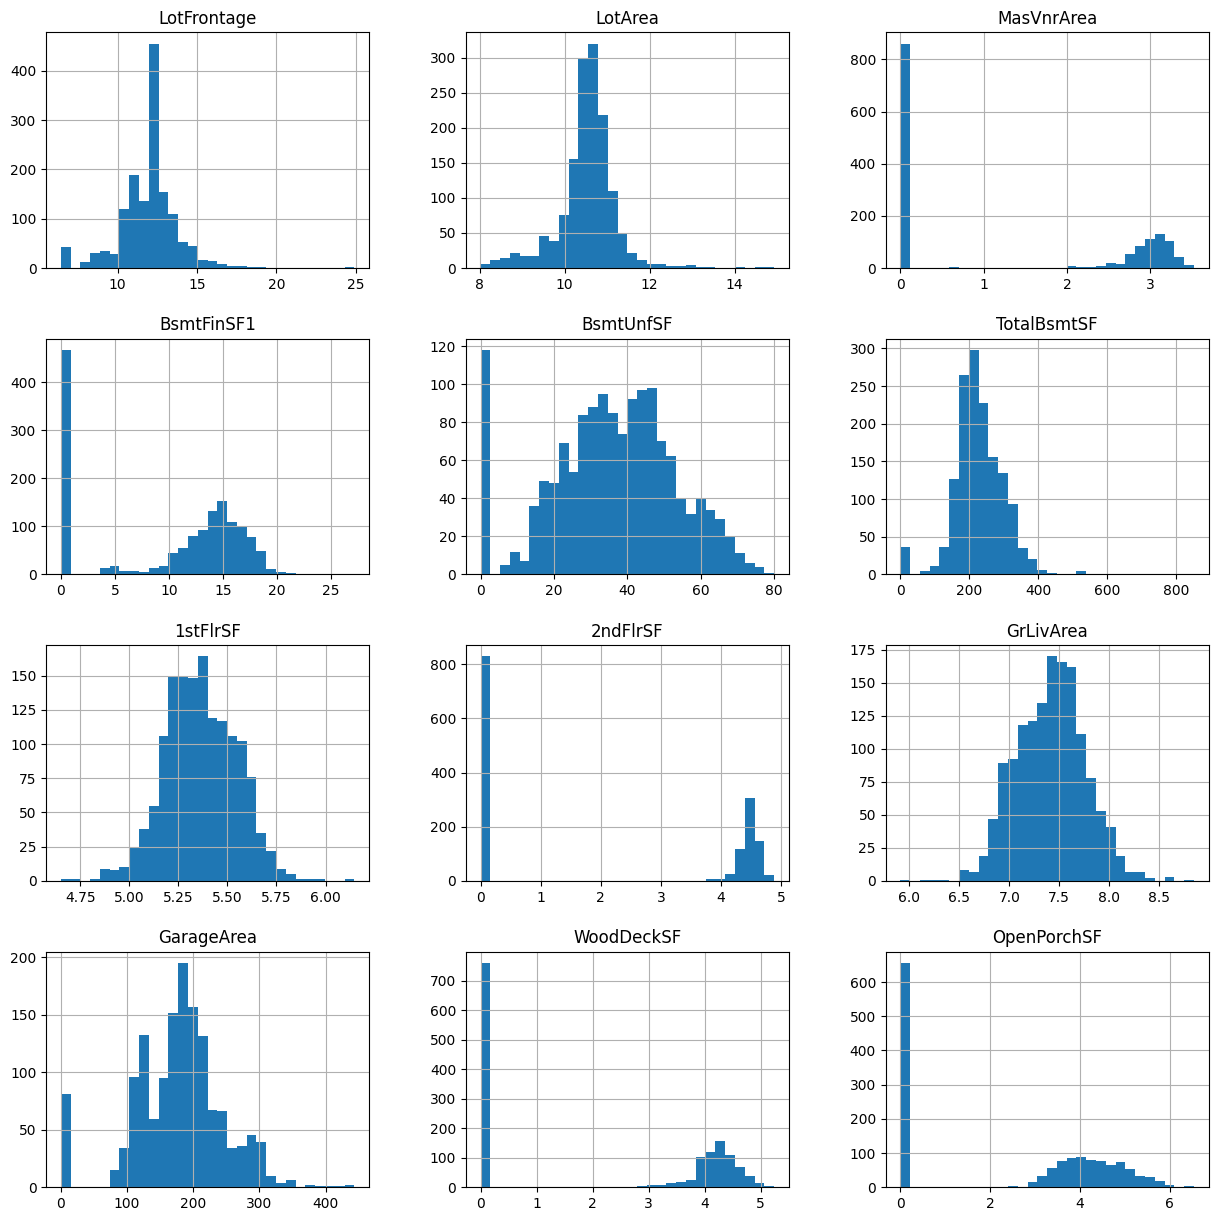

In [35]:
# Temporary copy of the data
tmp = train.copy()

# Check for non-finite values and handle them if necessary
non_finite_mask = ~tmp[continuous_var].apply(np.isfinite).all(axis=1)
if non_finite_mask.any():
    print(f"Found {non_finite_mask.sum()} rows with non-finite values.")
    tmp = tmp[~non_finite_mask]

# Apply Yeo-Johnson transformation
for var in continuous_var:
    tmp[var], param = stats.yeojohnson(tmp[var])

# Plot the histograms of the transformed variables
tmp[continuous_var].hist(bins=30, figsize=(15, 15))
plt.show()

In [36]:
for var in continuous_var:
    train[var], _ = stats.yeojohnson(train[var])
    Val[var], _, = stats.yeojohnson(Val[var])


#### 7.4 Skewed variables

Let's transform them into binary variables and see how predictive they are:

In [37]:
tmp = train.copy()
tmp = tmp.groupby('BsmtFinSF2')['SalePrice'].agg(['mean', 'std'])
tmp

,mean,std
BsmtFinSF2,,
0,12.029028,0.408677
28,11.918391,NaN
32,12.206073,NaN
35,11.872347,NaN
40,12.078239,NaN
...,...,...
1080,12.367341,NaN
1085,12.043554,NaN
1120,12.264342,NaN


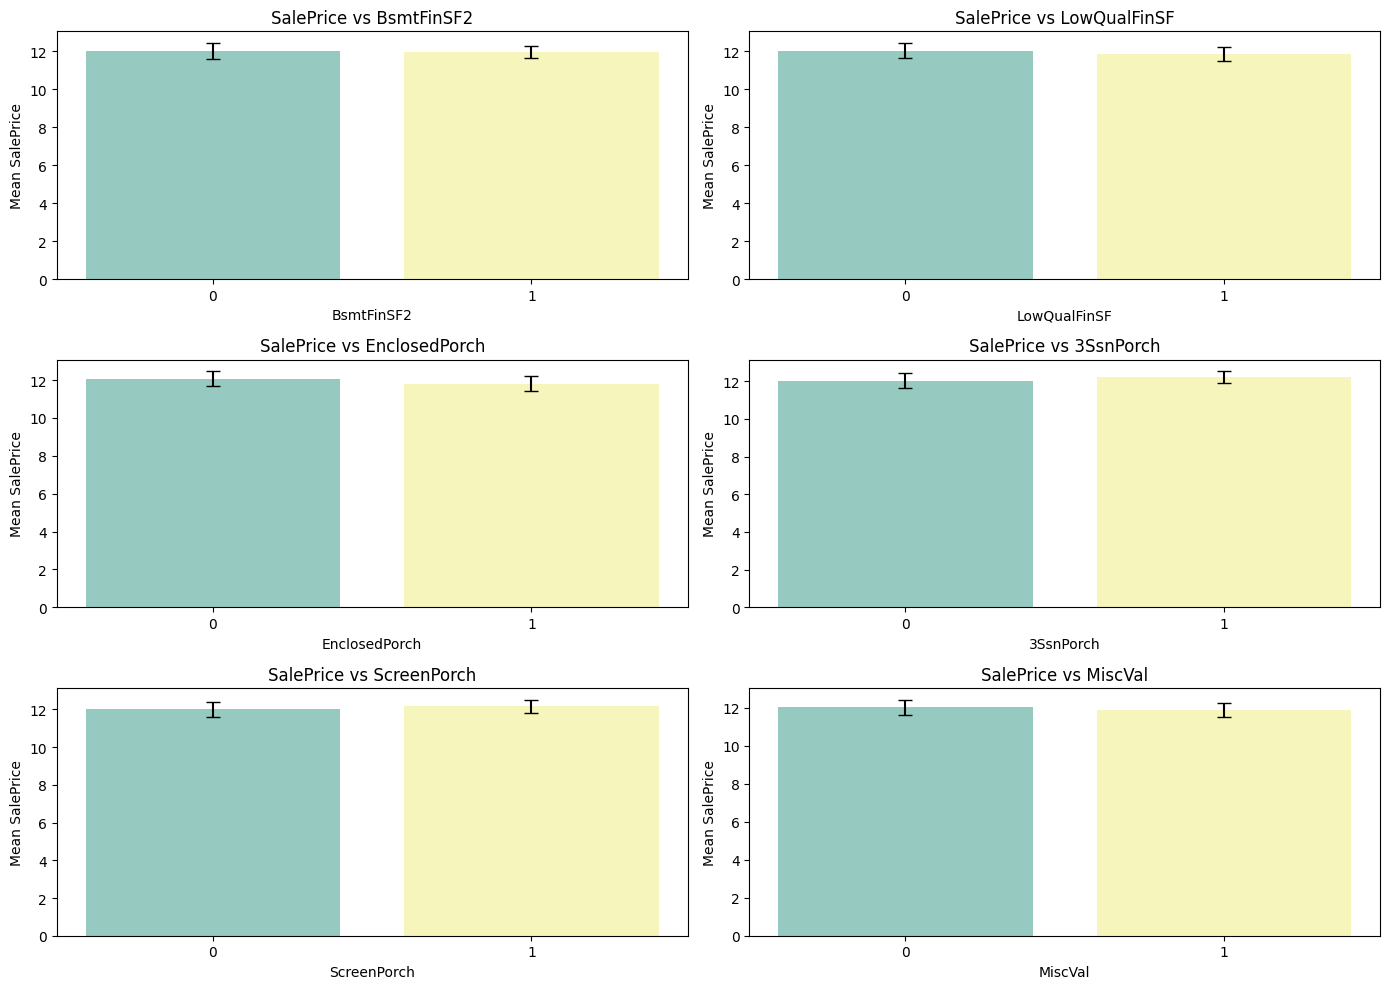

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,10))

for idx, var in enumerate(skewed):
    
    tmp = train.copy()
    
    tmp[var] = np.where(tmp[var] == 0, 0,1)
    tmp = tmp.groupby(var)['SalePrice'].agg(['mean','std']).reset_index()
    
    axes = axes.flatten()
    ax = axes[idx]
    
    sns.barplot(
        data = tmp,
        x = var,
        y = 'mean',
        ax = ax,
        palette = 'Set3'
    )
    
    
    # Add error bars manually using the standard deviation
    
    
    ax.errorbar(
        x = range(len(tmp)),
        y = tmp['mean'],
        yerr = tmp['std'],
        fmt = 'none',
        c = 'black',
        capsize=5
    )
    ax.set_title(f'SalePrice vs {var}')
    ax.set_ylabel('Mean SalePrice')
    ax.set_xlabel(var)

plt.tight_layout()
plt.show()
    

we can see that there is no difference in Sale Price in the mapped values, so it is not a good features to use.

--- 

**Processing 6:** `apply a binary skewed variables`

---



In [39]:
for var in skewed:
    
    # map the variable values into 0 and 1
    train[var] = np.where(train[var]==0, 0, 1)
    Val[var] = np.where(Val[var]==0, 0, 1)

---

<a id="08"></a>
### 8.Categorical variables
Let's go ahead and analyse the categorical variables present in the dataset.

In [40]:
print('Number of categorical variables: ', len(categorical_columns))

Number of categorical variables:  40


#### 8.1 Number of labels: cardinality


Let's evaluate how many different categories are present in each of the variables.


<Axes: >

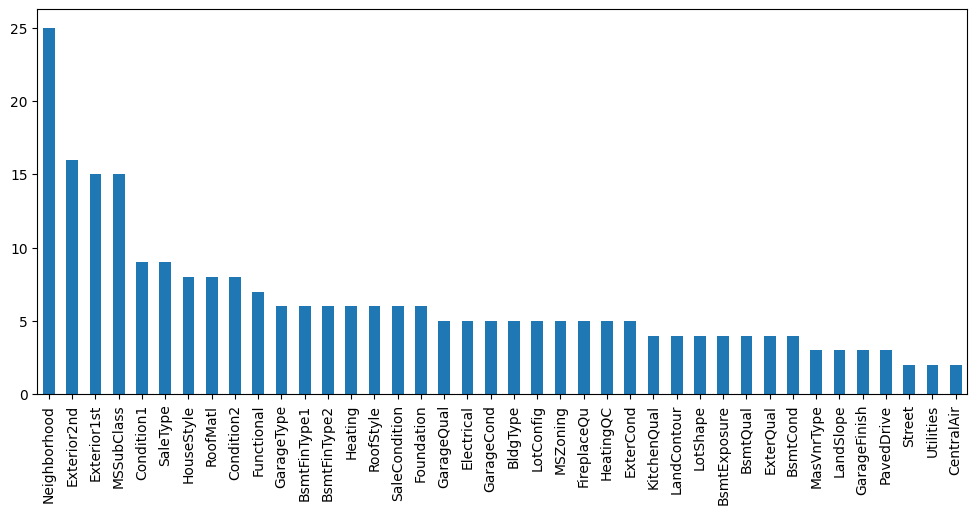

In [41]:

# we count unique categories with pandas unique() 
# and then plot them in descending order

train[categorical_columns].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

---

**Processing 7:** `Apply mappings`

---

All the categorical variables show low cardinality, this means that they have only few different labels. That is good as we won't need to tackle cardinality during our feature engineering lecture.

#### 8.2 Quality variables

There are a number of variables that refer to the quality of some aspect of the house, for example the garage, or the fence, or the kitchen. I will replace these categories by numbers increasing with the quality of the place or room.

The mappings can be obtained from the Kaggle Website. One example:

- Ex = Excellent
- Gd = Good
- TA = Average/Typical
- Fa = Fair
- Po = Poor

In [42]:
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

train[qual_vars].head(3)

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,Gd,TA,Gd,TA,Ex,Gd,Gd,TA,TA
1,TA,TA,Gd,TA,Ex,TA,TA,TA,TA
2,Gd,TA,Gd,TA,Ex,Gd,TA,TA,TA


In [43]:
print(len(qual_vars))

9


In [44]:
for col in qual_vars:
    print(f"{col}: {train[col].unique()}")

ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
ExterCond: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual: ['Gd' 'TA' 'Ex' 'Fa']
BsmtCond: ['TA' 'Gd' 'Fa' 'Po']
HeatingQC: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu: ['Gd' 'TA' 'Fa' 'Ex' 'Po']
GarageQual: ['TA' 'Fa' 'Gd' 'Ex' 'Po']
GarageCond: ['TA' 'Fa' 'Gd' 'Po' 'Ex']


In [45]:
# re-map strings to numbers, which determine quality
#___________________________________________________
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for var in qual_vars:
    train[var] = train[var].map(qual_mappings)
    Val[var] = Val[var].map(qual_mappings)


In [46]:
#___________________________________________________
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'Missing': 0, 'NA': 0}
var = 'BsmtExposure'
train[var] = train[var].map(exposure_mappings)
Val[var] = Val[var].map(exposure_mappings)

In [47]:

#___________________________________________________
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
finish_vars = ['BsmtFinType1', 'BsmtFinType2']
for var in finish_vars:
    train[var] = train[var].map(finish_mappings)
    Val[var] = Val[var].map(finish_mappings)

In [48]:
#___________________________________________________  
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
var = 'GarageFinish'
train[var] = train[var].map(garage_mappings)
Val[var] = Val[var].map(garage_mappings)

In [49]:
qual_vars = qual_vars + ['BsmtExposure','GarageFinish','BsmtFinType1', 'BsmtFinType2']
len(qual_vars)

13

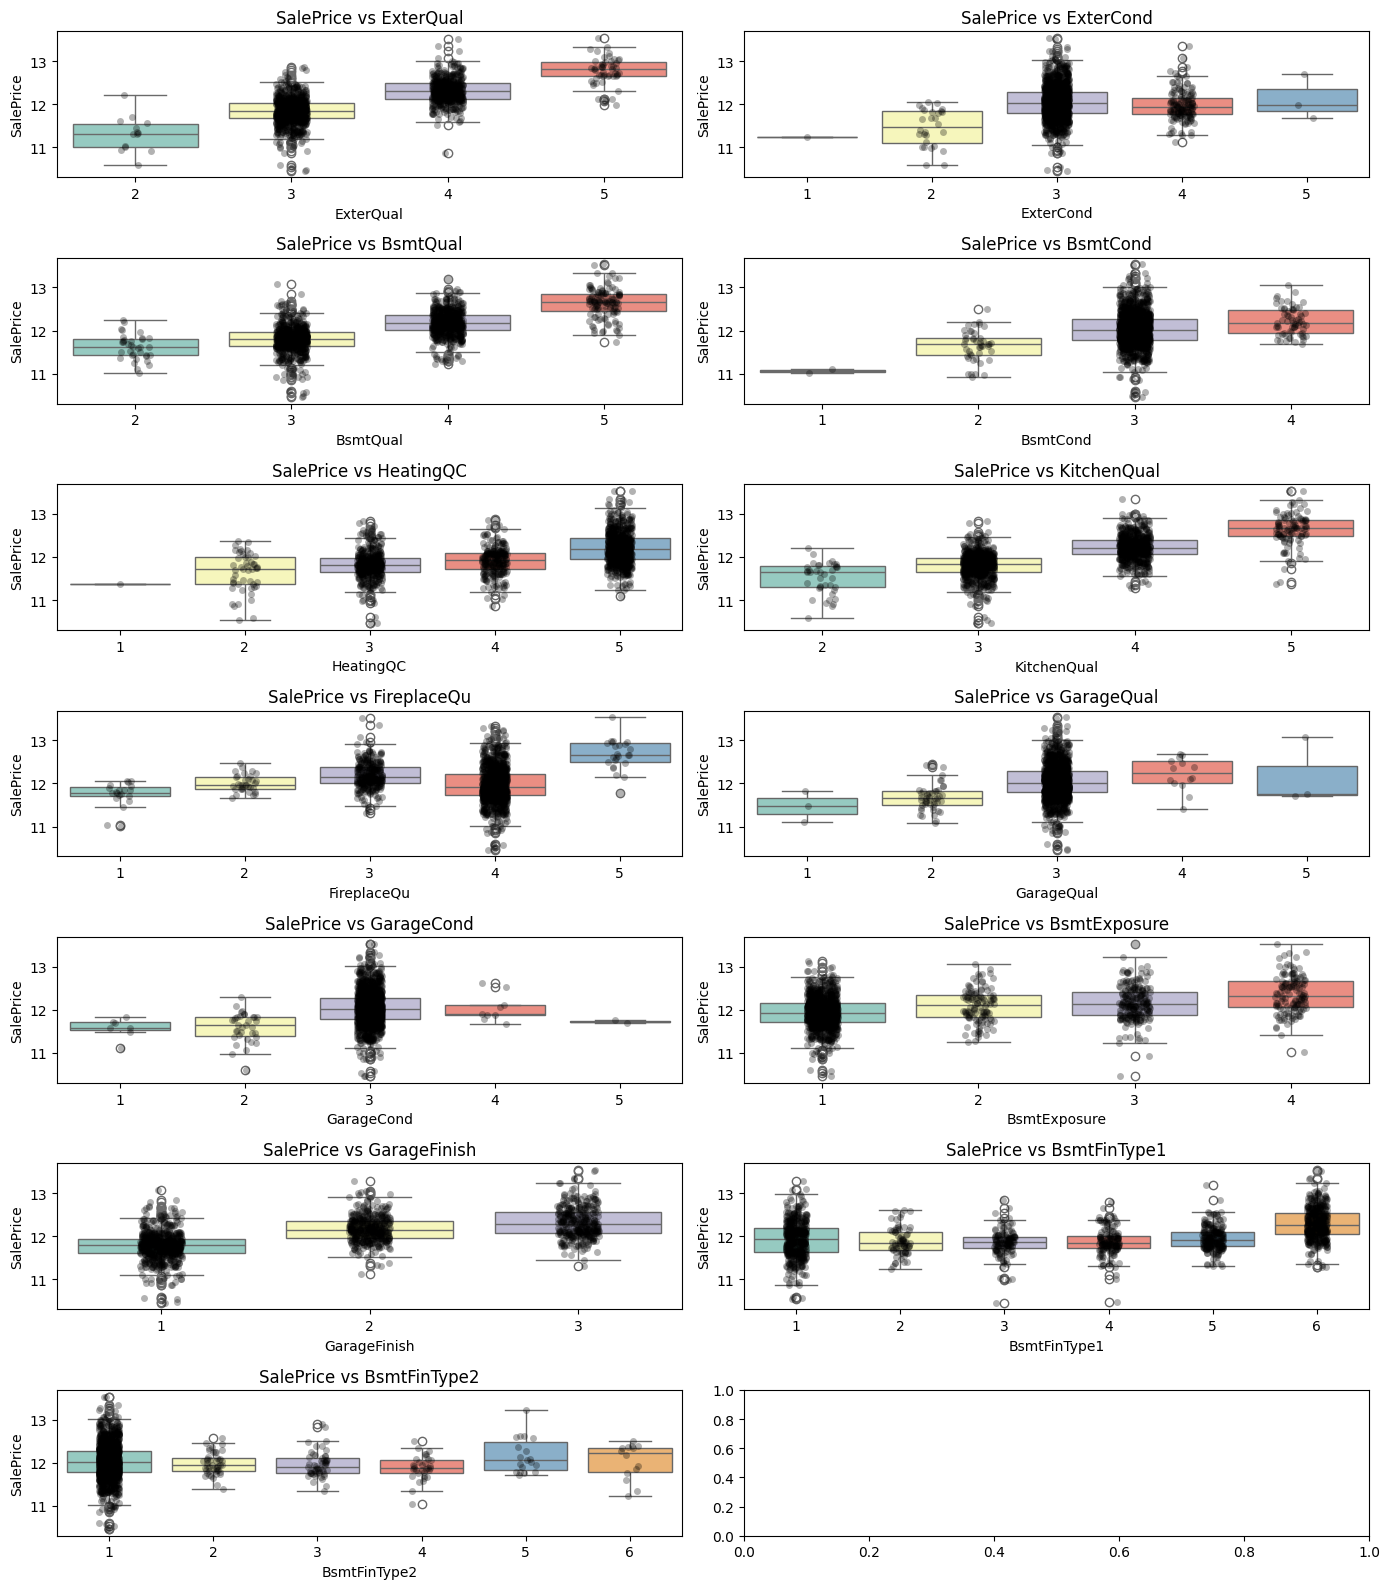

In [51]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize = (14, 16))
axes = axes.flatten()
for idx, var in enumerate(qual_vars):
    ax = axes[idx] 
    sns.boxplot(
        x=var,
        y='SalePrice',
        data=train,
        ax=ax,
        palette="Set3"
    )
    sns.stripplot(
        x=var,
        y='SalePrice',
        data=train,
        ax=ax,
        jitter=0.1,
        alpha=0.3,
        color='k'
    )
    ax.set_title(f'SalePrice vs {var}')
    
plt.tight_layout()
plt.show()

#### 8.3. Rare labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

In [52]:
cat_others = [
    var for var in categorical_columns if var not in qual_vars
]

len(cat_others)

27

In [53]:
cat_others

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [54]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_others:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    train[var] = np.where(train[var].isin(
        frequent_ls), train[var], 'Rare')
    

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Condition2 Index(['Norm'], dtype='object', name='Condition2')

BldgType Ind

---

<a id="08"></a>

### 8. Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers.

We will do it so that we capture the monotonic relationship between the label and the target.

In [55]:
def replace_categories(df, var, target):
    
    ordered_labels = df.groupby([var])[target].mean().sort_values().index
    
    # create the mapping dictionary 
    
    ordinal_label_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    print(var, ordinal_label_mapping)
    print()
    
    # replace the labels with the ordinal numbers
    df[var] = df[var].map(ordinal_label_mapping)
    
    
for var in cat_others:
    replace_categories(train, var, 'SalePrice')

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'Corner': 1, 'FR2': 2, 'Rare': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'BrkSide': 3, 'OldTown': 4, 'Edwards': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11, 'NWAmes': 12, 'Gilbert': 13, 'CollgCr': 14, 'Blmngtn': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'Rare': 3, 'RRAn': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Twnhs': 1, 'Duplex': 2, '1Fam': 3, 'TwnhsE': 4}

HouseStyle {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5}

RoofStyle {'Gable': 0, 'Rare': 1, 'Hip

---

<a id="09"></a>

### 9. Correlation matrix

In [56]:
correlation_matrix = train.corr()
target_correlation = correlation_matrix['SalePrice']

corr = target_correlation.sort_values(ascending=False).to_frame()
corr.style.background_gradient(cmap="RdYlBu")

,SalePrice
SalePrice,1.000000
OverallQual,0.817184
Neighborhood,0.739974
GrLivArea,0.730240
GarageCars,0.680625
ExterQual,0.678840
KitchenQual,0.667893
BsmtQual,0.657131
GarageArea,0.647471
TotalBsmtSF,0.612850


***let's remove the features that has no significance correlation with the target variable***

In [57]:
no_correlation_features = target_correlation[abs(target_correlation) < 0.06]
no_correlation_features

Street          0.057369
Utilities       0.012632
LandSlope       0.038526
Condition2      0.045333
OverallCond    -0.036868
ExterCond       0.049314
BsmtFinType2   -0.020634
BsmtFinSF2     -0.034682
LowQualFinSF   -0.056995
BsmtHalfBath   -0.005149
FireplaceQu    -0.048853
3SsnPorch       0.057857
MoSold          0.057329
Name: SalePrice, dtype: float64

In [58]:
low_correlation_columns = no_correlation_features.index.tolist()
low_correlation_columns


['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'OverallCond',
 'ExterCond',
 'BsmtFinType2',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'FireplaceQu',
 '3SsnPorch',
 'MoSold']

In [59]:
train = train.drop(columns=low_correlation_columns, axis=1)
Val = Val.drop(columns=low_correlation_columns, axis=1)

In [60]:
train.shape

(1460, 62)

In [61]:
Val.shape

(1459, 61)

---

<a id="10"></a>

### 10.Train Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['SalePrice'], axis=1), # predictive variables
    train['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 61), (146, 61))

---

<a id="11"></a>

### 11. Handling outliers

In [63]:
# handling outliers 

# outliers detection
features_with_outliers = []
for feature in train.columns:
    Q1 = train[feature].quantile(0.25)
    Q3 = train[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1-1.5*IQR
    upper = Q3+1.5*IQR
    if train[(train[feature]>upper)].any(axis=None) & train[(train[feature]<lower)].any(axis=None):
        features_with_outliers.append(feature)
        print(feature, "---> theres are outliers here ")
    else:
        print(feature, " ---> everything is good ")

MSSubClass  ---> everything is good 
MSZoning ---> theres are outliers here 
LotFrontage ---> theres are outliers here 
LotArea ---> theres are outliers here 
LotShape  ---> everything is good 
LandContour ---> theres are outliers here 
LotConfig  ---> everything is good 
Neighborhood  ---> everything is good 
Condition1 ---> theres are outliers here 
BldgType ---> theres are outliers here 
HouseStyle  ---> everything is good 
OverallQual  ---> everything is good 
YearBuilt  ---> everything is good 
YearRemodAdd  ---> everything is good 
RoofStyle  ---> everything is good 
RoofMatl  ---> everything is good 
Exterior1st  ---> everything is good 
Exterior2nd  ---> everything is good 
MasVnrType ---> theres are outliers here 
MasVnrArea  ---> everything is good 
ExterQual  ---> everything is good 
Foundation  ---> everything is good 
BsmtQual  ---> everything is good 
BsmtCond ---> theres are outliers here 
BsmtExposure  ---> everything is good 
BsmtFinType1  ---> everything is good 
Bsmt

In [64]:
print(len(features_with_outliers))
print(features_with_outliers)

19
['MSZoning', 'LotFrontage', 'LotArea', 'LandContour', 'Condition1', 'BldgType', 'MasVnrType', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType', 'SaleCondition', 'SalePrice']


In [65]:
def replace_outliers(df, columns):
    """
    Replaces outliers in specified columns with the upper or lower bound
    based on the IQR method.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of columns to check for outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced.
    """
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace values below the lower bound with the lower bound
        df[column] = df[column].apply(lambda x: max(x, lower_bound))
        # Replace values above the upper bound with the upper bound
        df[column] = df[column].apply(lambda x: min(x, upper_bound))
        
    return df

train = replace_outliers(train,features_with_outliers)

---

<a id="12"></a>

### 12. Data Scaling

In [66]:
X_train.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,8.042618,2.707002,11.941149,10.526375,0.429985,1.048706,0.504566,10.748858,1.980974,2.920091,...,2.973364,1.847032,2.006517,2.382479,0.142314,0.078387,2.643075,0.038052,2.006088,2.852359
std,3.385783,0.798034,1.850744,0.693677,0.648426,0.444037,1.056108,5.884204,0.625995,0.647574,...,0.240695,0.513529,2.125869,2.213511,0.349504,0.268881,39.504255,0.191394,0.465039,0.844929
min,0.000000,0.000000,6.421684,8.025002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,11.201981,10.280740,0.000000,1.000000,0.000000,6.000000,2.000000,3.000000,...,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000
50%,9.000000,3.000000,12.113014,10.586044,0.000000,1.000000,0.000000,10.000000,2.000000,3.000000,...,3.000000,2.000000,0.000000,3.320681,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000
75%,11.000000,3.000000,12.863913,10.849749,1.000000,1.000000,1.000000,14.000000,2.000000,3.000000,...,3.000000,2.000000,4.221773,4.340207,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000
max,12.000000,4.000000,24.915738,14.926127,3.000000,3.000000,4.000000,22.000000,5.000000,4.000000,...,5.000000,2.000000,5.240922,6.543559,1.000000,1.000000,738.000000,1.000000,3.000000,4.000000


In [67]:
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [68]:

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)


NameError: name 'MinMaxScaler' is not defined

In [397]:
X_train.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,0.670218,0.676750,0.298445,0.362459,0.143328,0.349569,0.126142,0.488584,0.396195,0.730023,0.670624,0.567309,0.271136,0.393954,0.210807,0.019026,0.665753,0.618798,0.541096,0.344832,0.465500,0.686263,0.519026,0.669964,0.217910,0.511568,0.352164,0.467506,0.267431,0.983257,0.787100,0.931507,0.960934,0.478176,0.402551,0.514592,0.140284,0.521055,0.192542,0.358352,0.348554,0.502537,0.377917,0.958143,0.205226,0.623668,0.275769,0.386225,0.440830,0.400660,0.493531,0.493341,0.923516,0.382856,0.364095,0.142314,0.078387,0.003581,0.038052,0.668696,0.713090
std,0.282149,0.199509,0.100072,0.100516,0.216142,0.148012,0.264027,0.267464,0.125199,0.161894,0.267461,0.154306,0.223713,0.338925,0.400501,0.136668,0.308151,0.343702,0.154350,0.421126,0.191736,0.292681,0.226496,0.096863,0.345849,0.414148,0.262203,0.225308,0.085211,0.115882,0.239404,0.252686,0.133926,0.120997,0.458477,0.118072,0.172657,0.183351,0.251858,0.102083,0.073166,0.222387,0.135607,0.169444,0.216310,0.245336,0.225872,0.405353,0.186588,0.158961,0.061369,0.060174,0.256764,0.405629,0.338273,0.349504,0.268881,0.053529,0.191394,0.155013,0.211232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.416667,0.750000,0.258478,0.326865,0.000000,0.333333,0.000000,0.272727,0.400000,0.750000,0.600000,0.444444,0.058824,0.081967,0.000000,0.000000,0.400000,0.300000,0.500000,0.000000,0.333333,0.500000,0.333333,0.666667,0.000000,0.000000,0.000000,0.326784,0.220436,1.000000,0.500000,1.000000,1.000000,0.392745,0.000000,0.430878,0.000000,0.333333,0.000000,0.250000,0.333333,0.333333,0.250000,1.000000,0.000000,0.250000,0.065421,0.000000,0.250000,0.302444,0.500000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.750000
50%,0.750000,0.750000,0.307738,0.371105,0.000000,0.333333,0.000000,0.454545,0.400000,0.750000,0.600000,0.555556,0.261029,0.254098,0.000000,0.000000,0.700000,0.700000,0.500000,0.000000,0.333333,0.500000,0.666667,0.666667,0.000000,0.600000,0.466462,0.480108,0.259740,1.000000,1.000000,1.000000,1.000000,0.474130,0.000000,0.522449,0.000000,0.666667,0.000000,0.375000,0.333333,0.333333,0

---

<a id="13"></a>

### 13. Save the results

In [415]:
# let's save the dataframes
X_train.to_csv('../Data/CleanedData/xtrain.csv', index=False)
X_test.to_csv('../Data/CleanedData/xtest.csv', index=False)

y_train.to_csv('../Data/CleanedData/ytrain.csv', index=False)
y_test.to_csv('../Data/CleanedData/ytest.csv', index=False)

# also we will save the validation dataset

Val.to_csv('../Data/CleanedData/val.csv', index=False)
# now let's save the scaler

joblib.dump(scaler, '../Data/processing/minmax_scaler.joblib') 

['../Data/processing/minmax_scaler.joblib']